# Mapping and classifying cells using Human Lung Cell Atlas

In this notebook, we will guide you through how to map your data to the [Human Lung Cell Atlas](https://www.biorxiv.org/content/10.1101/2022.03.10.483747v1) (core reference), perform label transfer, and more. For that purpose we use scArches, a method to map new single cell/single nucleus data to an existing reference (see also [Lotfollahi et al., Nature Biotechnology 2021](https://doi.org/10.1038/s41587-021-01001-7)). 

Import the needed modules. __Note that we use scArches version 0.3.5. and scvi-tools 0.8.1__ For efficiency of knn-graph and umap calculation, we recommend using scanpy>=1.8.2, umap-learn>0.5, and installing pynndescent: `pip install pynndescent`. If you used the conda environment provided on our GitHub repo, all of these packages were automatically installed with the correct versions, so no need to check!

#### Import modules:

In [1]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

In [2]:
import scanpy as sc
import numpy as np
import pandas as pd
import os
import scarches as sca
import urllib.request 
import gzip
import shutil

import scarches-based label transfer script and testdata import script:

In [3]:
import sys
sys.path.append("../scripts/")
import scarches_label_transfer
import data_import_and_cleaning

#### Set paths:

In [4]:
path_gene_order = "../supporting_files/HLCA_scarches_gene_order.csv"
path_embedding = "../data/HLCA_emb_and_metadata.h5ad"
path_HLCA_celltype_info = "../supporting_files/HLCA_celltypes_ordered.csv"
dir_ref_model = "../data/HLCA_reference_model"
dir_testdata = "../test"

Set output directory. Note that any existing directories with the same name will be overwritten!!

In [5]:
dir_out = "../testout" # adapt if wanted

#### set and print general settings, versions etc.

Set figure parameters (change for bigger/smaller plots):

In [6]:
sc.set_figure_params(figsize=(5,5))

We'll print versions of the imported modules here, for reproducibility purposes:

In [7]:
sc.logging.print_versions()

The `sinfo` package has changed name and is now called `session_info` to become more discoverable and self-explanatory. The `sinfo` PyPI package will be kept around to avoid breaking old installs and you can downgrade to 0.3.2 if you want to use it without seeing this message. For the latest features and bug fixes, please install `session_info` instead. The usage and defaults also changed slightly, so please review the latest README at https://gitlab.com/joelostblom/session_info.
-----
anndata     0.8.0
scanpy      1.8.2
sinfo       0.3.4
-----
PIL                         9.0.1
attr                        21.4.0
backcall                    0.2.0
beta_ufunc                  NA
binom_ufunc                 NA
cached_property             1.5.2
certifi                     2021.10.08
cffi                        1.15.0
charset_normalizer          2.0.12
cycler                      0.10.0
cython_runtime              NA
data_import_and_cleaning    NA
dateutil                    2.8.2
debugpy   

## Download reference model and embedding from zenodo

If you haven't done so already, download the HLCA core reference model and embedding that are available on zenodo (doi: 10.5281/zenodo.6337966, see https://zenodo.org/record/6337966#.Yid5Vi9Q28U). Make sure to put them in a folder named "data", in the repository parent directory (i.e. same directory that has folders "notebooks", "scripts" etc.). You can download yourself, or download from within this notebook, as is done below:

In [8]:
if not os.path.isdir("../data"):
    os.mkdir("../data")

move to data directory:

In [9]:
os.chdir("../data")

If not in your data directory yet, download files from zenodo from terminal.

In [10]:
%%bash
if ! [ -f HLCA_emb_and_metadata.h5ad ]; 
    then echo 'Downloading embedding from zenodo'
    wget -nv https://zenodo.org/record/6337966/files/HLCA_emb_and_metadata.h5ad
fi
if ! [ -d HLCA_reference_model ];
    then echo "Downloading reference model from zenodo"
    wget -nv https://zenodo.org/record/6337966/files/HLCA_reference_model.zip
    unzip HLCA_reference_model.zip
    rm HLCA_reference_model.zip
fi

Archive:  HLCA_reference_model.zip
   creating: HLCA_reference_model/
  inflating: HLCA_reference_model/var_names.csv  
  inflating: HLCA_reference_model/model_params.pt  
  inflating: HLCA_reference_model/attr.pkl  


2022-03-21 11:44:31 URL:https://zenodo.org/record/6337966/files/HLCA_emb_and_metadata.h5ad [217785664/217785664] -> "HLCA_emb_and_metadata.h5ad" [1]
2022-03-21 11:44:35 URL:https://zenodo.org/record/6337966/files/HLCA_reference_model.zip [5321666/5321666] -> "HLCA_reference_model.zip" [1]


move back to notebooks directory:

In [11]:
os.chdir("../notebooks")

### load HLCA reference objects:

These files can be downloaded from Zenodo (see beginning of notebook)

In [12]:
# gene order for scArches model
reference_gene_order = pd.read_csv(path_gene_order)
# reference embedding, including cell/sample/subject metadata:
reference_embedding = sc.read_h5ad(path_embedding)

## import query data (i.e. data to be mapped to HLCA reference):

### option 1: import test dataset:

Here we use an example dataset, from the Delorey et al. publication:  https://www.nature.com/articles/s41586-021-03570-8., data: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE171668.  We only use the fresh, single-cell sample from this dataset.

Create a directory to store the data (if it doesn't exist yet)

In [13]:
if not os.path.isdir(dir_testdata):
    print("Creating testdir:", dir_testdata)
    os.mkdir(dir_testdata)

Creating testdir: ../test


Download data from geo:

In [14]:
geo_data_url = "https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM5230027&format=file&file=GSM5230027%5F04%2DP103142%2DS149%2DR01%5Fraw%5Ffeature%5Fbc%5Fmatrix%2Eh5%2Egz"
geo_metadata_url = "https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE171668&format=file&file=GSE171668%5Flung%5Fmetadata%2Ecsv%2Egz"

In [15]:
# download raw count data 
urllib.request.urlretrieve(geo_data_url, f"{dir_testdata}/testfile.h5.gz")
# gunzip .gz file, and remove original
with gzip.open(f'{dir_testdata}/testfile.h5.gz', 'rb') as f_in:
    with open(f'{dir_testdata}/testfile.h5', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)
os.remove(f"{dir_testdata}/testfile.h5.gz")
# download metadata
urllib.request.urlretrieve(geo_metadata_url, f"{dir_testdata}/testmeta.csv.gz")

('../test/testmeta.csv.gz', <http.client.HTTPMessage at 0x7f3ffb61b250>)

import the test query data into python:

In [16]:
query_data_full = data_import_and_cleaning.import_testdata(dir_testdata)

subset to 2000 genes used for mapping, and pad missing genes with zeros:

In [17]:
query_data = data_import_and_cleaning.subset_and_pad_adata_object(query_data_full, reference_gene_order)

Gene names detected: ensembl gene ids.
1993 genes detected out of 2000 used for mapping.
Not all genes were recovered, filling in zeros for 7 missing genes...


#### Option 2: load your own data:

import data:

In [18]:
### query_data_full = sc.read(....)

As scArches only works with 2000 genes, and these have to be exactly in the same order in your query data as they were originally in the reference, it is important that you run the following function:

In [19]:
### query_data = data_import_and_cleaning.subset_and_pad_adata_object(query_data_full, reference_gene_order)

Alternatively, you can manually do this, using the reference_gene_order dataframe.

IMPORTANT:  
Make sure that you have raw (i.e. un-normalized, integer) counts in your data (.X layer)!!

# Prepare query data for mapping: 

check gene order:

In [20]:
if (query_data.var.index == reference_gene_order.gene_symbol).all() or (
    query_data.var.index == reference_gene_order.gene_id
).all():
    print("Gene order is correct.")
else:
    print(
        "WARNING: your gene order does not match the order of the HLCA reference. Fix this before continuing!"
    )

Gene order is correct.


Make sure that you have raw data in query_data.X. We will now copy that information to query_data.raw for scArches.

In [21]:
query_data.raw = query_data
raw = query_data.raw.to_adata()
raw.X = query_data.X
query_data.raw = raw

quick check if X and raw.X have integers (do a more systematic check if you have any doubts!):

In [22]:
query_data.raw.X[:10, :10].toarray()

array([[  0.,   1.,   1.,   0., 103.,   0.,   1.,   0.,   2.,   0.],
       [  0.,   2.,   0.,   0.,  66.,   0.,  16.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,  64.,   0.,   5.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,  36.,   0.,   9.,   0.,   0.,   0.],
       [  0.,   2.,   0.,   0.,  15.,   0.,   3.,   0.,   0.,   0.],
       [  0.,   1.,   0.,   0.,  41.,   0.,   3.,   0.,   1.,   0.],
       [  0.,   1.,   0.,   0.,  40.,   0.,   1.,   0.,   0.,   0.],
       [  0.,   3.,   1.,   0.,  27.,   0.,   1.,   0.,   0.,   0.],
       [  0.,   2.,   0.,   0.,  51.,   0.,   2.,   0.,   0.,   0.],
       [  0.,   2.,   0.,   0.,  42.,   0.,   1.,   0.,   0.,   0.]],
      dtype=float32)

In [23]:
query_data.X[:10, :10].toarray()

array([[  0.,   1.,   1.,   0., 103.,   0.,   1.,   0.,   2.,   0.],
       [  0.,   2.,   0.,   0.,  66.,   0.,  16.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,  64.,   0.,   5.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,  36.,   0.,   9.,   0.,   0.,   0.],
       [  0.,   2.,   0.,   0.,  15.,   0.,   3.,   0.,   0.,   0.],
       [  0.,   1.,   0.,   0.,  41.,   0.,   3.,   0.,   1.,   0.],
       [  0.,   1.,   0.,   0.,  40.,   0.,   1.,   0.,   0.,   0.],
       [  0.,   3.,   1.,   0.,  27.,   0.,   1.,   0.,   0.,   0.],
       [  0.,   2.,   0.,   0.,  51.,   0.,   2.,   0.,   0.,   0.],
       [  0.,   2.,   0.,   0.,  42.,   0.,   1.,   0.,   0.,   0.]],
      dtype=float32)

Set query_data.obs["scanvi_label"] to "unlabeled". Keep this code as is, it has to do with the way the reference model was set up. 

In [24]:
query_data.obs["scanvi_label"] = "unlabeled"

### Perform surgery on reference model and train on query dataset without cell type labels

### Set scArches parameters:

Store the set of batches from your query data. This might just be a single batch.  
In the extended HLCA, we have treated datasets as batches. If you expect large batch effects between subsets of your data, it is better to spit your dataset into multiple datasets. For example, if you have data that is a mixture of 5' and 3' data, it would be better to consider those separate batches.

In [25]:
batch_variable = "dataset"  # the column name under which you stored your batch variable
query_batches = sorted(query_data.obs[batch_variable].unique())
print(query_batches)

['test_dataset_delorey_regev']


These are the parameter settings we used for the extended HLCA, as recommended by the scArches developers:

In [26]:
surgery_epochs = 500
early_stopping_kwargs_surgery = {
    "early_stopping_metric": "elbo",
    "save_best_state_metric": "elbo",
    "on": "full_dataset",
    "patience": 10,
    "threshold": 0.001,
    "reduce_lr_on_plateau": True,
    "lr_patience": 8,
    "lr_factor": 0.1,
}

Now perform scArches "surgery". The result will be stored in the output dir specified above. Each dataset/batch has its own "adapter" that will be trained separately, and will be stored in the output_dir under a folder named after the batch.  
Note: if you use gene names rather than ensembl IDs in your query_data.var.index, you will get a warning that your genes (var_names) do not match the training genes. You can ignore this warning, as long as you have done the gene check in the beginning of the notebook.

In [27]:
for batch in query_batches: # this loop is only necessary if you have multiple batches, but will also work for a single batch.
    print("Batch:", batch)
    query_subadata = query_data[query_data.obs[batch_variable] == batch,:].copy()
    print("Shape:", query_subadata.shape)
    # load model and set relevant variables:
    model = sca.models.SCANVI.load_query_data(
        query_subadata,
        dir_ref_model,
        freeze_dropout = True,
    )
    model._unlabeled_indices = np.arange(query_subadata.n_obs)
    model._labeled_indices = []
    # now train surgery model using reference model and target adata
    model.train(
        n_epochs_semisupervised=surgery_epochs,
        train_base_model=False,
        semisupervised_trainer_kwargs=dict(
            metrics_to_monitor=["accuracy", "elbo"], 
            weight_decay=0,
            early_stopping_kwargs=early_stopping_kwargs_surgery
        ),
        frequency=1
    )
    surgery_path = os.path.join(dir_out,batch)
    if not os.path.exists(surgery_path):
        os.makedirs(surgery_path)
    model.save(surgery_path, overwrite=True)

Batch: test_dataset_delorey_regev
Shape: (1786, 2000)
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 1786 cells, 2000 vars, 15 batches,
         29 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0     
         extra continuous covariates.                                                        
INFO     Training Unsupervised Trainer for 400 epochs.                                       
INFO     Training SemiSupervised Trainer for 500 epochs.                                     
INFO     KL warmup for 400 epochs                                                            
Training...:  57%|█████▋    | 285/500 [02:05<01:34,  2.28it/s]INFO                                  

to reload specific models, use the following code (not necessary if you run this script in one go)

In [28]:
# surgery_path = f"{output_dir}/{batch}"
# model = sca.models.SCANVI.load_query_data(query_data, 'surgery_model', freeze_dropout=True) # this is before training

In [29]:
# surgery_path = f"{output_dir}/{batch}"
# model = sca.models.SCANVI.load(surgery_path,query_data) # if already trained

### Get the latent representation of your query dataset

Here we will calculate the "latent representation", or "low-dimensional embedding" of your dataset. This embedding is in the same space as the HLCA core/reference embedding that you loaded in the beginning of the script. Hence, we can combine the two embeddings afterwards (HLCA + your new data), and do joint clustering, UMAP embedding, label transfer etc.! 

Create an empty dataframe to store the embeddings of all batches:

In [30]:
emb_df = pd.DataFrame(index=query_data.obs.index,columns=range(0,reference_embedding.shape[1]))

Calculate embeddings, using the trained scArches model:

In [31]:
for batch in query_batches: # from small to large datasets
    print(f"Working on {batch}...")
    query_subadata = query_data[query_data.obs[batch_variable] == batch,:].copy()
    surgery_path = os.path.join(dir_out, batch)
    model = sca.models.SCANVI.load(surgery_path, query_subadata)
    query_subadata_latent = sc.AnnData(model.get_latent_representation(adata=query_subadata))
    # copy over .obs
    query_subadata_latent.obs = query_data.obs.loc[query_subadata.obs.index,:]
    query_subadata_latent.write(os.path.join(surgery_path, "emb.h5ad"))
    emb_df.loc[query_subadata.obs.index,:] = query_subadata_latent.X

Working on test_dataset_delorey_regev...
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 1786 cells, 2000 vars, 15 batches,
         29 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0     
         extra continuous covariates.                                                        


Convert final embedding (of all your query batches) to an anndata object:

In [32]:
query_embedding = sc.AnnData(X=emb_df.values, obs=query_data.obs)

## Combine the embedding of the HLCA and the query data

Add query vs. reference information:

In [33]:
query_embedding.obs['HLCA_or_query'] = "query"
reference_embedding.obs['HLCA_or_query'] = "HLCA"

We will now combine the two embeddings to enable joing clustering etc. If you expect non-unique barcodes (.obs index), set index_unique to e.g. "_" and batch_key to the obs column that you want to use as barcode suffix (e.g. "dataset").

In [34]:
# concatenate source and target data
combined_emb = reference_embedding.concatenate(query_embedding, index_unique=None) # index_unique="_", batch_key="dataset") # alternative

Note that if wanted, this embedding can be added to the full, joint HLCA + query data object (including gene counts). The full HLCA, including normalized counts is publicly available. For now, we will just work with the embedding, since that is all we need to perform joint plotting and label transfer.

## Downstream analysis: plotting and label transfer

#### umap plotting:

We can now do joint downstream analysis, such as clustering, UMAP embedding, label transfer etc. 

Note that the knngraph + umap calculation can take quite a while. See notes at the top of this notebook for speeding up the process.

In [35]:
sc.pp.neighbors(combined_emb, n_neighbors=30)

In [36]:
sc.tl.umap(combined_emb)

Now we can start plotting umaps, here is just one example:

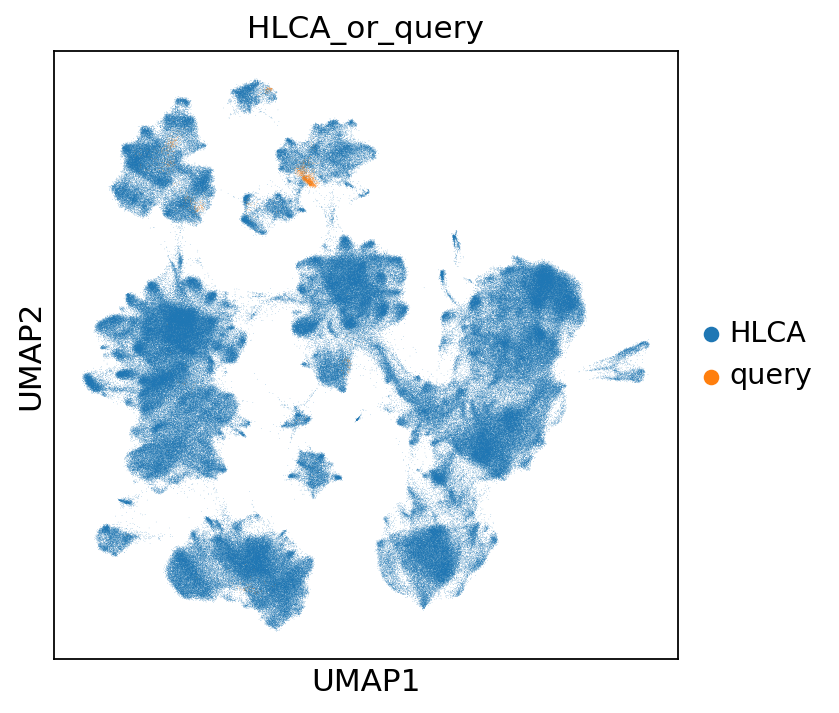

In [37]:
sc.pl.umap(combined_emb, color="HLCA_or_query")

Store result, if wanted:

In [38]:
combined_emb.write(os.path.join(dir_out,"combined_embedding.h5ad"))

Any other graph-based or latent-space based downstream method can also be used, based on the embedding and the above-calculated graph. We will proceed to label transfer here.

## Label transfer:

Next, we use a knn classifier to transfer the lables from the reference to the query. We do this for every level of the annotation (i.e. level 1-5).  
Note that some cell types don't have annotations for higher levels, e.g. mast cells do not have level 4 or 5 annotations. For those cell types, we "propagate" to the higher levels, i.e. you will see "3_Mast cells" in level 4 and 5 annotations. (Most cell types don't have a level 5 annotation!) Therefore, all highest level annotations can be found under level 5.

Import the set of finest cell type labels, and their matching lower-level annotations (cell types are also ordered in a biologically sensible order in this table, you can use this order for downstream plotting etc. if wanted):

In [39]:
cts_ordered = pd.read_csv(path_HLCA_celltype_info,index_col=0)    

Now run the label transfer commands. Note that this might take quite a while if you have a large query dataset! For our small test dataset, it should not take long.

In [40]:
# run k-neighbors transformer
k_neighbors_transformer = scarches_label_transfer.weighted_knn_trainer(
    train_adata=reference_embedding,
    train_adata_emb="X", # location of our joint embedding
    n_neighbors=50,
    )    
# perform label transfer
labels, uncert = scarches_label_transfer.weighted_knn_transfer(
    query_adata=query_embedding,
    query_adata_emb="X", # location of our joint embedding
    label_keys="Level",
    knn_model=k_neighbors_transformer,
    ref_adata_obs = reference_embedding.obs.join(cts_ordered, on='ann_finest_level')
    )

Weighted KNN with n_neighbors = 50 ... finished!


With the commands above, we labeled every cell from the query. However, some cells might have high label transfer uncertainty. It is useful to set those to "unknown" instead of giving them a cell type label. This will help highlight cell types/states that are new (i.e. not present in the reference) and possible interesting, they're worth taking a careful look at!

This is the uncertainty threshold we use in the paper, limiting the false positive rate to <0.5:

In [41]:
uncertainty_threshold = 0.2

We will now copy the unfiltered cell type labels ("Level_[level]_transfered_label_unfiltered"), the uncertainty scores ("Level_[level]_transfer_uncert") and the filtered cell type labels (i.e. including "unknown", "Level_[level]_transfered_label") to our combined_emb object.

In [42]:
labels.rename(columns={f"Level_{lev}":f"Level_{lev}_transfered_label_unfiltered" for lev in range(1,6)},inplace=True)
uncert.rename(columns={f"Level_{lev}":f"Level_{lev}_transfer_uncert" for lev in range(1,6)},inplace=True)

In [43]:
combined_emb.obs = combined_emb.obs.join(labels)
combined_emb.obs = combined_emb.obs.join(uncert)
# convert to arrays instead of categoricals, and set "nan" to NaN 
for col in combined_emb.obs.columns:
    if col.endswith("_transfer_uncert"):
        combined_emb.obs[col] = list(np.array(combined_emb.obs[col]))
    elif col.endswith("_transfered_label_unfiltered"):
        filtered_colname = col.replace("_unfiltered","")
        matching_uncert_col = col.replace("transfered_label_unfiltered","transfer_uncert")
        
        # also create a filtered version, setting cells with too high 
        # uncertainty levels to "Unknown"
        combined_emb.obs[filtered_colname] = combined_emb.obs[col]
        combined_emb.obs[filtered_colname].loc[combined_emb.obs[matching_uncert_col]>uncertainty_threshold] = "Unknown"
        # convert to categorical:
        combined_emb.obs[col] = pd.Categorical(combined_emb.obs[col])
        combined_emb.obs[filtered_colname] = pd.Categorical(combined_emb.obs[filtered_colname])
        # then replace "nan" with NaN (that makes colors better in umap)
        combined_emb.obs[col].replace("nan",np.nan,inplace=True)
        combined_emb.obs[filtered_colname].replace("nan",np.nan,inplace=True)

/home/icb/lisa.sikkema/miniconda3/envs/HLCA_mapping_env/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Let's take a look at the percentage of cells set to "unknown" after our filtering:

In [44]:
print(f"Percentage of unknown per level, with uncertainty_threshold={uncertainty_threshold}:")
for level in range(1,6):
    print(f"Level {level}: {np.round(sum(combined_emb.obs[f'Level_{level}_transfered_label'] =='Unknown')/query_data.n_obs*100,2)}%")

Percentage of unknown per level, with uncertainty_threshold=0.2:
Level 1: 0.56%
Level 2: 0.9%
Level 3: 9.8%
Level 4: 50.78%
Level 5: 50.9%


Here we show label transfer uncertainties per level. Regions with high uncertainty can highlight interesting cell types/states, not present in the reference. Note that uncertainties will get higher, the more detailed we go:

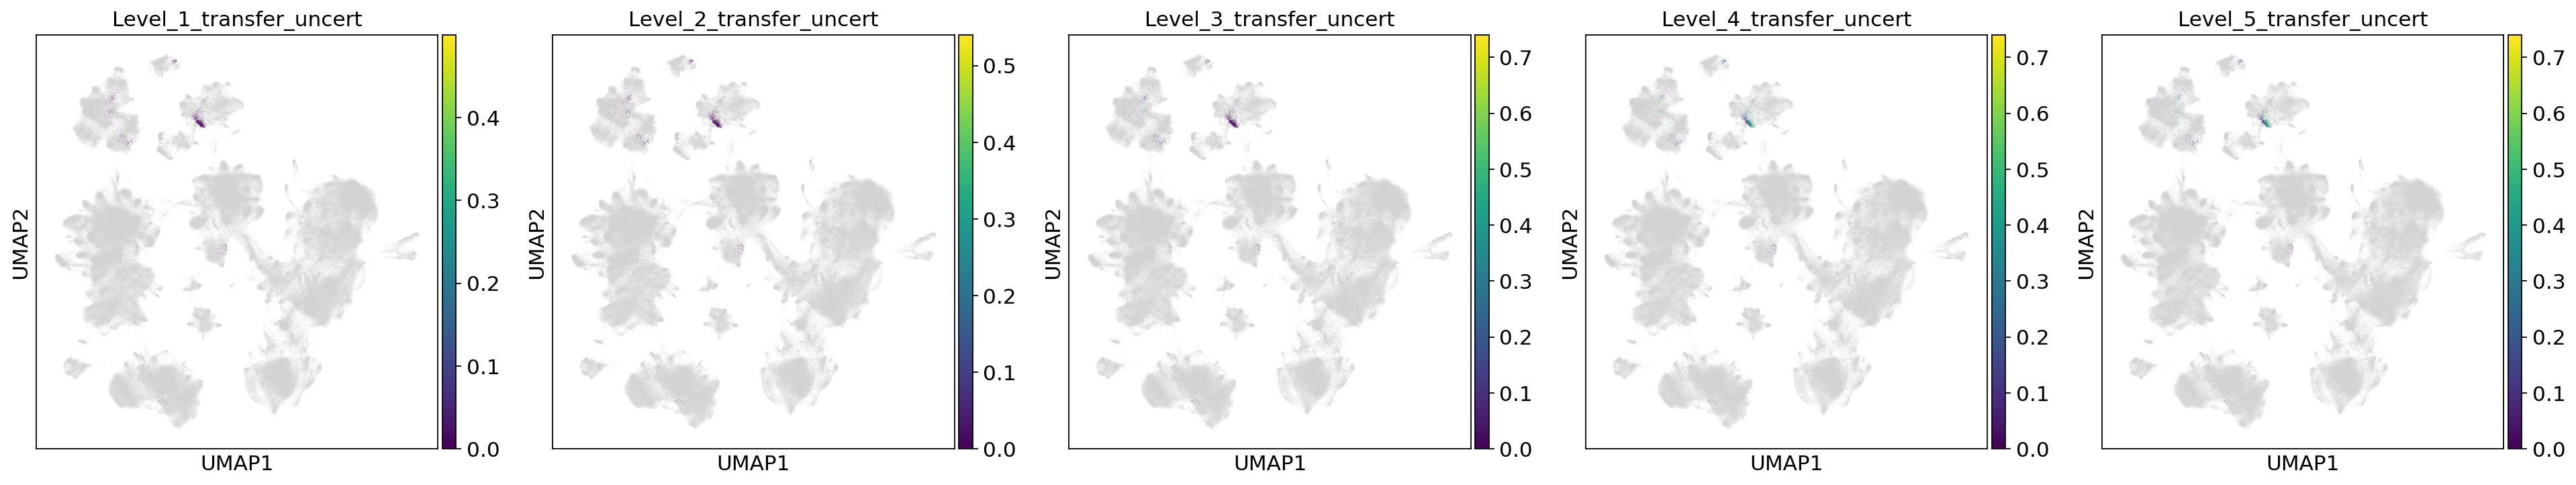

In [45]:
sc.pl.umap(combined_emb,color=[f"Level_{lev}_transfer_uncert" for lev in range(1,6)],ncols=5)

Now let's take a look at the transfered labels, at every level. Note that the color for "Unknown" switches per plot.

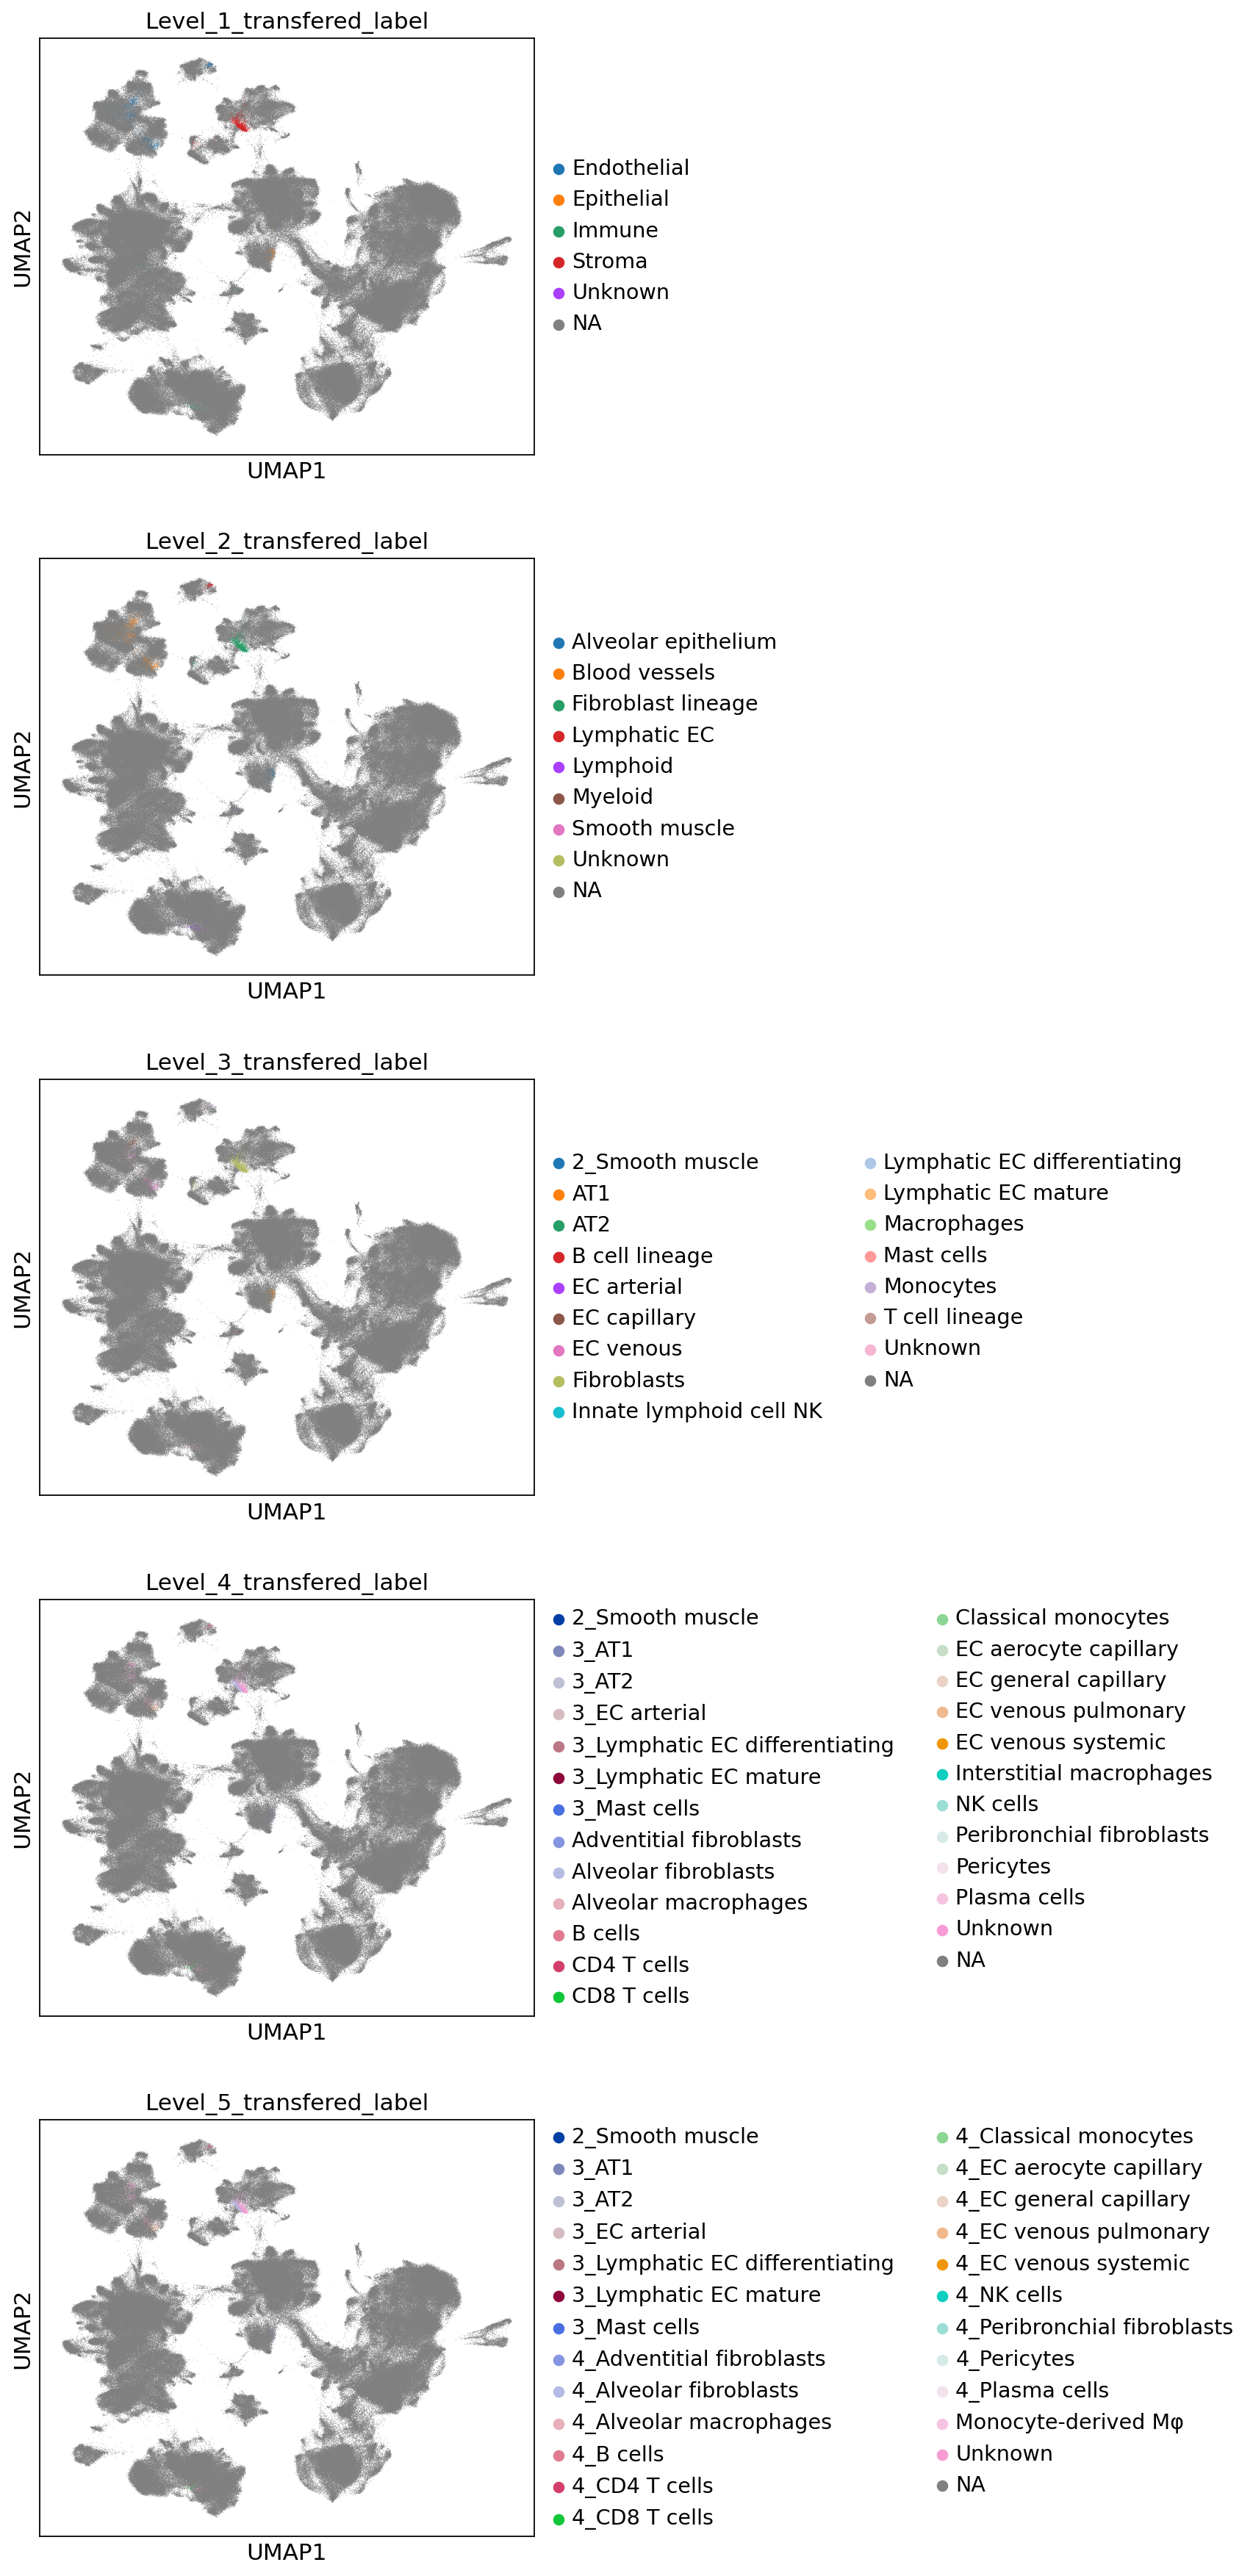

In [46]:
sc.pl.umap(combined_emb,color=[f"Level_{lev}_transfered_label" for lev in range(1,6)],na_color="grey",ncols=1,size=0.5)

For your reference, these are the annotations of the reference atlas:

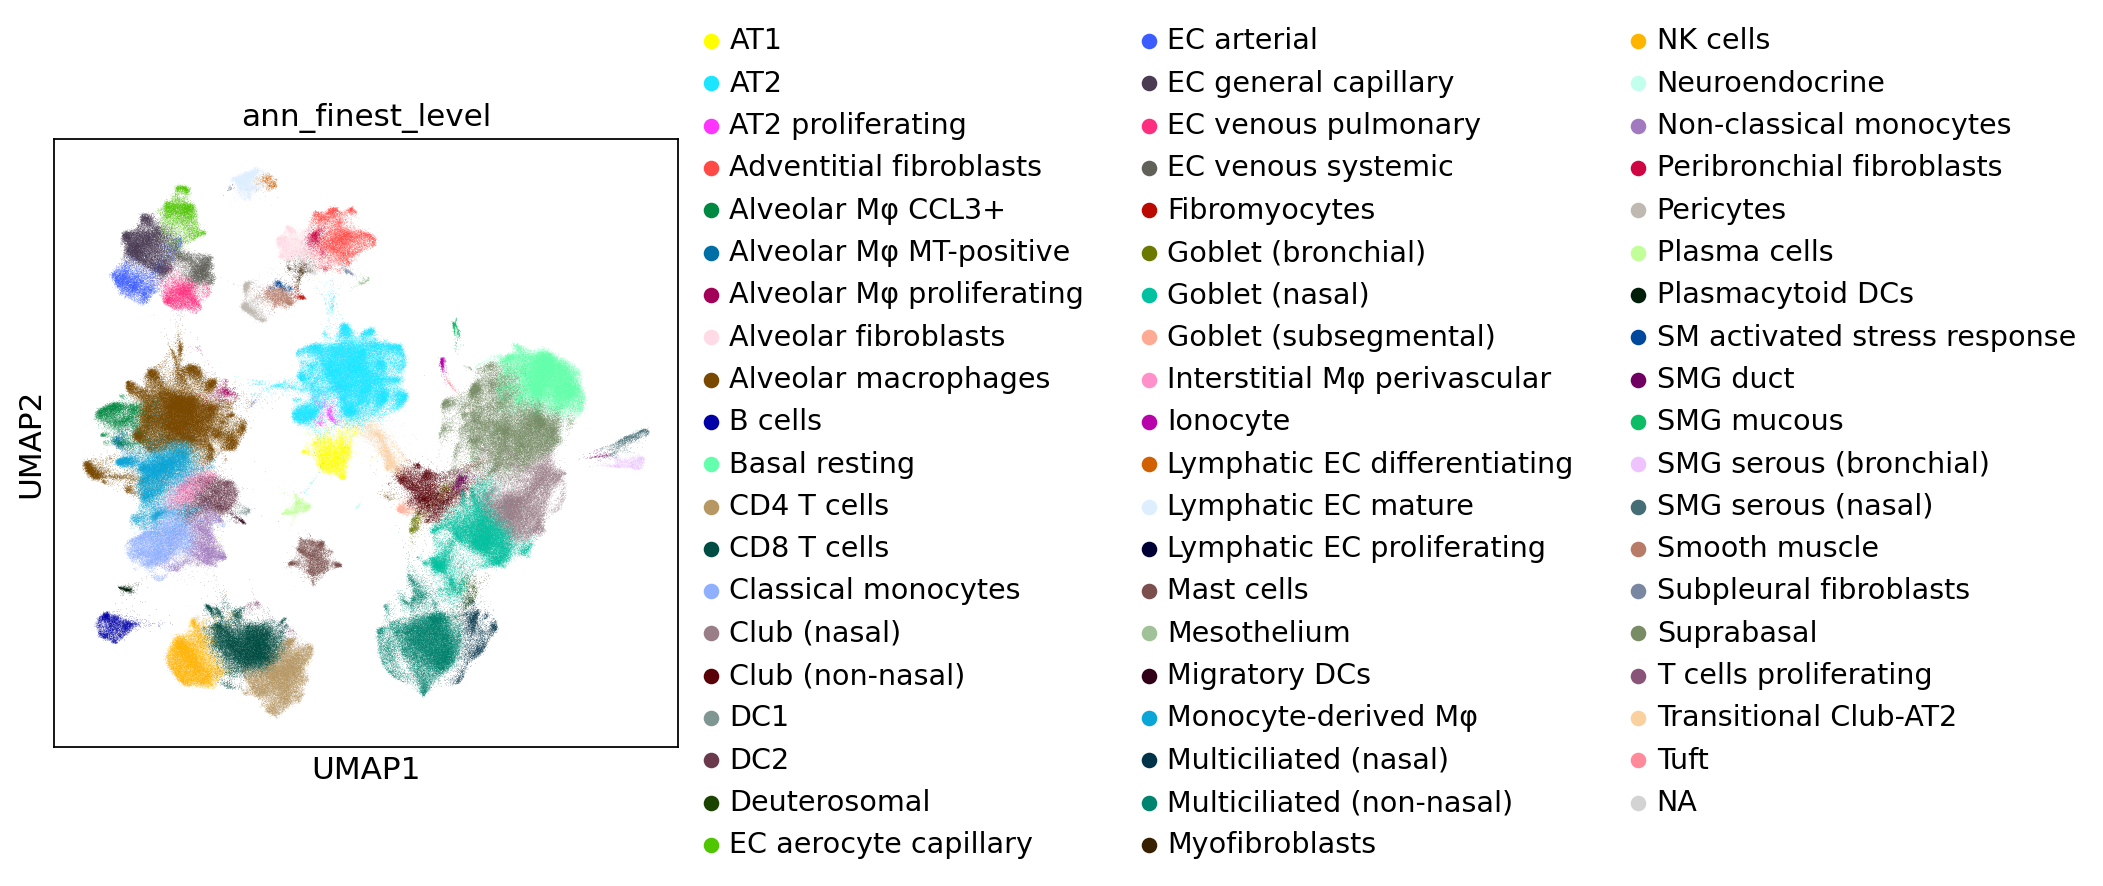

In [47]:
sc.pl.umap(combined_emb, color="ann_finest_level")

Store the resulting combined embedding, now including transferred labels:

In [48]:
combined_emb.write(os.path.join(dir_out,"combined_embedding.h5ad"))